In [1]:
import os
from datetime import datetime, date
from sklearn import utils
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as fn
import torch.optim as optim

device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
plt.style.use('ggplot')

### 0. Utils

### 1-1. Preprocessor

In [2]:
class Preprocessor:
    def _fit_transform(self, raw):
        result = raw.copy()

        result = self._n_comment_to_float(result)
        result = self._str_to_datetype(result)
        result = self._add_n_hashtag(result)
        
        self.non_numeric = ['channel', 'title', 'genre', 'description', 'date', 'sign_in']
        result = self._merge(result, self.non_numeric)
        
        features = ['cumul_view', 'n_dislike', 'n_like', 'n_comment', 'video_n_view', 'cumul_subs']
        new_name = ['view_diff', 'dislike_diff', 'like_diff', 'comment_diff', 'video_n_view_diff', 'sub_diff']
        result = self._add_diff(result, features, new_name)
        
        result = self._add_no_upload_interval(result)
        result = self._remove_nan(result)
        self._one_hot(result)

        return result
        
        
        
    #FEATRUES TO ADD & MODIFY
    ####################################################################     
    def _n_comment_to_float(self,result):
        idx1 = result['n_comment'] == '댓글 사용 중지'
        idx2 = result.n_comment.isna()
        idx = idx1|idx2
        result['n_comment'].loc[idx] = result['n_comment'].loc[idx].apply(lambda x: 0)
        result['n_comment'] = result['n_comment'].astype(float)
        return result
        
    
    def _str_to_datetype(self,result):
        if pd.api.types.is_datetime64_ns_dtype(result['date']):
            pass
        else:
            result['date'] = pd.to_datetime(result['date'])
        return result
    
    
    def _add_n_hashtag(self,result):
        result['n_hashtage'] = 0
        idx = result['description'].notnull()
        result.loc[idx, 'n_hashtage'] = result.loc[idx, 'description'].apply(lambda x: len(x.split('#'))-1)
        return result
        
    
    @staticmethod
    def _get_to_merge(data, numeric, non_numeric):
        data = data.reset_index(drop=True)
        num_to_add = data.title.shape[0] - data.title.isna().sum()
        data = pd.concat((data.loc[0,non_numeric], data[numeric].mean()))
        data['video_num'] = num_to_add
        return data
    def _merge(self, result, non_numeric):
        #operate both merge and creating video_num featrue simultaneously.
        numeric = [col for col in result.columns.tolist() if col not in non_numeric]
        return result.groupby(['channel', 'date']).apply(lambda x: self._get_to_merge(x, numeric, non_numeric)).reset_index(drop=True)
    
    
    @staticmethod
    def _get_diff(result, feature, new_name):
        result = result.reset_index(drop=True)
        result[new_name] = (result[feature] - result[feature].shift())
        return result
    def _add_diff(self, result, feature, new_name):
        result = result.groupby('channel').apply(lambda x: self._get_diff(x, feature, new_name)).reset_index(drop=True)
        result[new_name] = result[new_name].fillna(0)
        return result
    
    
    @staticmethod
    def _get_no_upload_interval(result):
        result = result.reset_index(drop=True)
        upload_idx = result[result['video_num'] != 0].index.tolist()
        temp = [0 for i in range(result.shape[0])]
        for i in range(len(upload_idx)):
            if i == len(upload_idx)-1:
                former = upload_idx[i]
                temp[former+1:] = [i+1 for i in range(len(temp[former+1:]))]
            else:
                former, latter = upload_idx[i], upload_idx[i+1]
                temp[former+1:latter] = [i+1 for i in range(len(temp[former+1:latter]))]
        result['no_upload_interval'] = temp
        return result
    def _add_no_upload_interval(self,result):
        return result.groupby('channel').apply(lambda x: self._get_no_upload_interval(x)).reset_index(drop=True)
    
    
    def _remove_nan(self, result):
        numeric = [col for col in result.columns.tolist() if col not in self.non_numeric]
        result.loc[:, numeric] = result.loc[:,numeric].fillna(0)
        return result
    
    
    def _one_hot(self, data):
        data.loc[:,'genre'] = data.genre.fillna('etc')
        genre = data.genre.unique().tolist()
        for i, name in enumerate(genre):
            data.genre[data.genre==name] = data.genre[data.genre==name].apply(lambda x: i)
            
        one_hot = pd.get_dummies(data.genre.unique().tolist())
        data['one_hot'] = data.genre
        for i in range(len(one_hot)):
            data.loc[data.genre==i,'one_hot'] = data.loc[data.genre==i, 'genre'].apply(lambda x: one_hot[i].values)
    ####################################################################
    
    
    
    #CREATE SEQUENTIAL DATA
    ####################################################################
    def _extract_at_least_filter(self, result, filter_size):
        #fillter_size 이상인 채널 추출하기
        alive_idx = result['channel'].value_counts() >= filter_size
        alive_array = alive_idx[alive_idx==True].index
        return result[result['channel'].isin(alive_array)].reset_index(drop=True)
    
    
    @staticmethod
    def _to_sequential(result, filter_size, target_size, stride, features, target_features):
        result = result.reset_index(drop=True)
        idx_list = result.index.tolist()
        
        train, target = [],[]
        for i in range((len(idx_list)-filter_size-target_size)//stride +1):
            train_idx = idx_list[i*stride : i*stride + filter_size]
            target_idx = idx_list[i*stride + filter_size : i*stride + filter_size + target_size]
            train_temp = result.loc[train_idx,:].values.reshape(1,-1)
            target_temp = result.loc[target_idx,target_features].values.reshape(1,-1)
            
            train = train_temp.copy() if i == 0 else np.vstack([train, train_temp])
            target = target_temp.copy() if i == 0 else np.vstack([target, target_temp])
            
        train = pd.DataFrame(train, columns = result.columns.tolist()*filter_size)
        target = pd.DataFrame(target, columns = target_features*target_size)
        return train[features], target
    def _create_sequential_data(self, result, filter_size=7, target_size=1, stride=1, features=None, target_features=None):
        #remove channels with few information with respect to filter_size and target_size to extract
        result = self._extract_at_least_filter(result, filter_size + target_size)
        
        #features: features to drop fromf X (features)
        #target_features: features to extract from Y (targets)
        if features is None:
            features = ['date', 'genre','title', 'channel', 'description',	'sign_in', 'current_cumul_view', 'current_n_video', 'current_cumul_subs']
        if target_features is None:
            target_features = ['sub_diff']
        
        #return train, target set wrt groups
        result = result.groupby('channel').apply(lambda x: self._to_sequential(x, filter_size, target_size, stride, features, target_features)).reset_index(drop=True)
        return self._combine(result)
    
    
    def _combine(self, result):
        temp0, temp1 = [], []
        for i in range(len(result)):
            temp0.append(result[i][0])
            temp1.append(result[i][1])
        temp0 = pd.concat(temp0)
        temp1 = pd.concat(temp1)
        return (temp0, temp1)
    ####################################################################


    
    #SCALE
    ####################################################################
    def scale(self, data, return_original_scale=True):
        original_scale = pd.concat((data.max(), data.min()), axis=1).T
        original_scale.index=['max', 'min']
        scaler = preprocessing.MinMaxScaler()
        data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
        if return_original_scale:
            return data, original_scale
        return data
    
        
    def inverse_scale(self, pred, scl):
        for idx in range(pred.shape[1]):
            pred.iloc[:,idx] = (scl.iloc[0,idx]-scl.iloc[1,idx])*pred.iloc[:,idx]+scl.iloc[1,idx]

### 1-2. Data Loader

In [3]:
class Loader(Preprocessor):
    def __init__(self, path):
        self._raw = pd.read_csv(path)
        self.data = super()._fit_transform(self._raw.copy())
        print('Data Loaded. :P')
        
        
    def get_data(self, filter_size=7, target_size=1, stride=1, features=None, target_features=None,
                         channel:list=None, shuffle=False, random_state=None, order=None):
        if channel is None:
            data_to_extract = self.data
        else:
            channels = self.list_channel[channel].tolist()
            data_to_extract = self.data.set_index('channel').loc[channels].reset_index()
            
        train, target = self._create_sequential_data(data_to_extract, filter_size, target_size, stride, features, target_features)
        if shuffle:
            train, target = utils.shuffle(train, target, random_state=random_state)
        
        if order:
            train_col = [col for col in train.columns.unique().tolist()]
            target_col = [col for col in target.columns.unique().tolist()]
            train, target = train[train_col], target[target_col]
            
        return train, target

    
    @property
    def list_features(self):
        #list the entire features, hence you can choose which features are included in whole set.
        return self.data.columns.tolist()
    
    @property
    def list_channel(self):
        #list indices of channel.
        return pd.Series(self.data.channel.unique().tolist())

> load함수

In [4]:
def load(
    filter_size: '60, 90, 180', 
    target_size: '1, 7, 30, 180', 
    stride: '1, 2, 3',
    drop_suffix: '각 변수 끝에 붙은 번호를 제거할지 여부'=True,
    path='/home/mskang/CapstoneUOS/notebooks/ModelResearch_iloveslowfood/data_variants'):
    
    print(f'Setting: filter_size({filter_size})\ttarget_size({target_size})\tstride({stride})\tdrop_suffix({drop_suffix})')
    X_name = f'fs({filter_size})_ts({target_size})_st({stride}).csv'
    y_name = f'fs({filter_size})_ts({target_size})_st({stride})_label.csv'
    
    print('Load feature data...', end='\t')
    X = pd.read_csv(os.path.join(path, X_name))
    print('loaded!')
    print('Load label data...', end='\t')
    y = pd.read_csv(os.path.join(path, y_name))
    print('loaded!')
    
    if drop_suffix:
        X.columns = list(map(lambda x: x.split('.')[0], X.columns.tolist()))
        y.columns = list(map(lambda x: x.split('.')[0], y.columns.tolist()))
    return X, y

> 데이터 불러오기

In [6]:
filter_size = 90
target_size = 1
stride = 1
X, y = load(filter_size, target_size, stride)

Setting: filter_size(90)	target_size(1)	stride(1)	drop_suffix(True)
Load feature data...	loaded!
Load label data...	loaded!


> Train/Test/VAlid 분할

In [7]:
random_state = 42
test_size = 0.2

X_trn, X_test, y_trn, y_test = train_test_split(
    X, y, 
    shuffle=True, 
    test_size=test_size, 
    random_state=random_state
) 

X_train, X_valid, y_train, y_valid = train_test_split(
    X_trn, y_trn, 
    shuffle=True, 
    test_size=test_size, 
    random_state=random_state
) 

### 스케일링 필요 시 다음을 진행(타깃에 대한 스케일링은 진행되지 않음)

In [8]:
from sklearn.preprocessing import MinMaxScaler

In [9]:
# scaler = MinMaxScaler()
# X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
# X_valid_scaled = pd.DataFrame(scaler.transform(X_valid), columns=X_valid.columns)
# X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

### 2D TO 3D

In [10]:
def stack_to_multi(df):
    feature_num=len(set(df.columns))
    window_num=int(df.shape[1]/feature_num)
    sample_num=int(df.shape[0])
    temp=np.empty([sample_num,window_num,feature_num])
    for i in range(feature_num):
        temp[:,:,i]=df.iloc[:,window_num*i:window_num*i+window_num]
    
    return temp
    

In [11]:
X_train

,duration,duration,duration,duration,duration,duration,duration,duration,duration,duration,...,no_upload_interval,no_upload_interval,no_upload_interval,no_upload_interval,no_upload_interval,no_upload_interval,no_upload_interval,no_upload_interval,no_upload_interval,no_upload_interval
151191,0.000,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,91,92,93,94,95,96,97,98,99,100
182565,0.000,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0,0,0,0,1,2,3,4,5,6
3868,46.520,0.00,0.0,0.00,0.00,48.82,0.00,0.00,0.00,0.00,...,5,0,1,2,3,4,5,0,1,2
156859,13.520,0.00,0.0,0.00,18.50,0.00,0.00,15.35,0.00,0.00,...,52,53,54,55,56,57,58,59,60,61
155688,0.000,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,98,99,100,101,102,103,104,105,106,107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91568,4.365,0.00,0.0,0.00,0.00,2.58,4.33,6.15,0.00,3.70,...,1,2,0,1,2,3,0,0,0,0
22528,7.430,7.92,5.8,7.42,0.00,6.98,6.70,7.22,5.62,8.13,...,0,0,1,0,0,0,0,0,0,1
157781,0.000,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,3,4,5,6,7,8,0,1,2,3
170685,0.000,0.00,0.0,0.00,2.17,0.00,2.62,0.00,0.00,0.00,...,5,6,7,8,9,10,11,12,13,14


In [12]:
X_train_3d=stack_to_multi(X_train)
X_valid_3d=stack_to_multi(X_valid)
X_test_3d=stack_to_multi(X_test)

In [13]:
print(X_train_3d.shape)
print(X_valid_3d.shape)
print(X_test_3d.shape)

(121872, 90, 17)
(30468, 90, 17)
(38085, 90, 17)


In [14]:
print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)

(121872, 1)
(30468, 1)
(38085, 1)


#### 3D 스케일링, 타겟 스케일링

In [15]:
from sklearn.preprocessing import MinMaxScaler
scaler=preprocessing.MinMaxScaler()
#scaler_y=preprocessing.MinMaxScaler()
def fit_3d(x_train,x_val,x_test):
    x_train_sample = x_train.shape[0] #샘플 개수
    x_val_sample=x_val.shape[0]
    x_test_sample=x_test.shape[0]
    
    x_timestep = x_train.shape[1] # timestep
    x_feature = x_train.shape[2]# feature 차원 
    scaler=MinMaxScaler()
    for ss in range(x_timestep):
        scaler.partial_fit(x_train[:, ss, :]) # 순회피팅

    results1,results2,results3=([],[],[])
    for ss in range(x_timestep):
        results1.append(scaler.transform(x_train[:, ss, :]).reshape(x_train_sample, 1, x_feature))
        results2.append(scaler.transform(x_val[:,ss,:]).reshape(x_val_sample,1,x_feature))
        results3.append(scaler.transform(x_test[:,ss,:]).reshape(x_test_sample,1,x_feature))
    df_train_scaled = np.concatenate(results1, axis=1) #합치기.
    df_val_scaled=np.concatenate(results2,axis=1)
    df_test_scaled=np.concatenate(results3,axis=1)
    
    
    
    return df_train_scaled,df_val_scaled,df_test_scaled

In [16]:
X_train_scaled,X_valid_scaled,X_test_scaled=fit_3d(X_train_3d, X_valid_3d, X_test_3d)

> target shape 변경 ( 샘플 x 타입스텝 x 예측일수)

In [22]:
X_train_subdiff=X_train['sub_diff']
X_valid_subdiff=X_valid['sub_diff']
X_test_subdiff=X_test['sub_diff']

In [23]:
X_train_subdiff[:]

,sub_diff,sub_diff,sub_diff,sub_diff,sub_diff,sub_diff,sub_diff,sub_diff,sub_diff,sub_diff,...,sub_diff,sub_diff,sub_diff,sub_diff,sub_diff,sub_diff,sub_diff,sub_diff,sub_diff,sub_diff
151191,4.0,0.0,10.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
182565,200.0,200.0,200.0,200.0,200.0,100.0,100.0,200.0,100.0,200.0,...,300.0,400.0,299.0,701.0,600.0,700.0,700.0,199.0,201.0,300.0
3868,25.0,25.0,60.0,20.0,50.0,40.0,30.0,40.0,20.0,60.0,...,40.0,10.0,40.0,32.0,33.0,32.0,33.0,50.0,10.0,40.0
156859,500.0,600.0,600.0,300.0,400.0,400.0,1200.0,500.0,500.0,600.0,...,1000.0,0.0,0.0,0.0,1000.0,0.0,0.0,0.0,250.0,250.0
155688,130.0,60.0,90.0,90.0,290.0,340.0,550.0,160.0,160.0,150.0,...,29.0,28.0,28.0,28.0,28.0,29.0,43.0,44.0,43.0,44.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91568,0.0,200.0,200.0,100.0,200.0,0.0,200.0,100.0,200.0,100.0,...,100.0,200.0,100.0,100.0,200.0,200.0,100.0,100.0,100.0,100.0
22528,100.0,100.0,299.0,101.0,200.0,100.0,200.0,100.0,100.0,100.0,...,300.0,450.0,451.0,550.0,550.0,350.0,350.0,700.0,700.0,300.0
157781,0.0,0.0,0.0,-100.0,0.0,0.0,0.0,0.0,0.0,-100.0,...,-50.0,-50.0,0.0,-100.0,0.0,0.0,-50.0,-50.0,0.0,0.0
170685,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
# (샘플개수 , (180+30)의 TARGET
temp1=pd.concat([X_train_subdiff,y_train],axis=1)
temp2=pd.concat([X_valid_subdiff,y_valid],axis=1)
temp3=pd.concat([X_test_subdiff,y_test],axis=1)

In [25]:
# (샘플, timestep, targetsize)
y_train_3d=np.empty((X_train_subdiff.shape[0],X_train_subdiff.shape[1],1)) # 30 : targetsize
y_valid_3d=np.empty((X_valid_subdiff.shape[0],X_valid_subdiff.shape[1],1))
y_test_3d=np.empty((X_test_subdiff.shape[0],X_test_subdiff.shape[1],1))

In [26]:
for t in range(X_train_subdiff.shape[1]): # 180 Timestep
    y_train_3d[:,t]=temp1.iloc[:,t:t+1]
    y_valid_3d[:,t]=temp2.iloc[:,t:t+1]
    y_test_3d[:,t]=temp3.iloc[:,t:t+1]

In [27]:
print(y_train_3d.shape)
print(y_valid_3d.shape)
print(y_test_3d.shape)

(121872, 90, 1)
(30468, 90, 1)
(38085, 90, 1)


> y scaling

In [28]:
y_train_temp=y_train_3d.reshape(-1,1)
y_valid_temp=y_valid_3d.reshape(-1,1)
y_test_temp=y_test_3d.reshape(-1,1)

In [29]:
scaler_y=MinMaxScaler()
y_train_scaled=scaler_y.fit_transform(y_train_temp)
y_val_scaled=scaler_y.transform(y_valid_temp)
y_test_scaled=scaler_y.transform(y_test_temp)

In [30]:
y_train_scaled=y_train_scaled.reshape(y_train_3d.shape[0],y_train_3d.shape[1],y_train_3d.shape[2])
y_valid_scaled=y_val_scaled.reshape(y_valid_3d.shape[0],y_valid_3d.shape[1],y_valid_3d.shape[2])
y_test_scaled=y_test_scaled.reshape(y_test_3d.shape[0],y_test_3d.shape[1],y_test_3d.shape[2])

In [31]:
print(y_train_scaled.shape)
print(y_valid_scaled.shape)
print(y_test_scaled.shape)

(121872, 90, 1)
(30468, 90, 1)
(38085, 90, 1)


> MODEL

In [32]:
import tensorflow as tf
from tensorflow import keras

> 마지막 Timestep의 loss만 중요하다.

In [33]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_absolute_error(Y_true[:, -1], Y_pred[:, -1]) #### <<- 

### Wavenet

>MODEL

In [42]:
filename='Wavenet(90_1_1).h5'
callback_list1 = [tf.keras.callbacks.ModelCheckpoint(filepath='Checkpoint/{}'.format(filename),
                                                    monitor='val_last_time_step_mse',
                                                    verbose=1,
                                                    save_best_only=True,
                                                    mode='min'),
                 tf.keras.callbacks.EarlyStopping(monitor='val_last_time_step_mse',
                                                  patience=15)]

In [43]:
model_Full=keras.models.Sequential()
model_Full.add(keras.layers.InputLayer(input_shape=[None,17]))
for rate in (1,2,4,8)*2:
    model_Full.add(keras.layers.Conv1D(filters=20,kernel_size=2,padding="causal",
                                 activation='relu',dilation_rate=rate))
model_Full.add(keras.layers.Conv1D(filters=1,kernel_size=1))
model_Full.compile(loss="mae", optimizer='adam', metrics=[last_time_step_mse])

In [44]:
model_Full.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_27 (Conv1D)           (None, None, 20)          700       
_________________________________________________________________
conv1d_28 (Conv1D)           (None, None, 20)          820       
_________________________________________________________________
conv1d_29 (Conv1D)           (None, None, 20)          820       
_________________________________________________________________
conv1d_30 (Conv1D)           (None, None, 20)          820       
_________________________________________________________________
conv1d_31 (Conv1D)           (None, None, 20)          820       
_________________________________________________________________
conv1d_32 (Conv1D)           (None, None, 20)          820       
_________________________________________________________________
conv1d_33 (Conv1D)           (None, None, 20)         

In [45]:
history_Full= model_Full.fit(X_train_scaled, y_train_scaled, epochs=100,
                    validation_data=(X_valid_scaled,y_valid_scaled),callbacks=callback_list1)

Epoch 1/100
3808/3809 [============================>.] - ETA: 0s - loss: 0.0011 - last_time_step_mse: 0.0011
Epoch 00001: val_last_time_step_mse improved from inf to 0.00104, saving model to Checkpoint/Wavenet(90_1_1).h5
3809/3809 [==============================] - 111s 29ms/step - loss: 0.0011 - last_time_step_mse: 0.0011 - val_loss: 9.9924e-04 - val_last_time_step_mse: 0.0010
Epoch 2/100
3809/3809 [==============================] - ETA: 0s - loss: 8.4395e-04 - last_time_step_mse: 8.5259e-04
Epoch 00002: val_last_time_step_mse improved from 0.00104 to 0.00063, saving model to Checkpoint/Wavenet(90_1_1).h5
3809/3809 [==============================] - 121s 32ms/step - loss: 8.4395e-04 - last_time_step_mse: 8.5259e-04 - val_loss: 6.6050e-04 - val_last_time_step_mse: 6.3281e-04
Epoch 3/100
3809/3809 [==============================] - ETA: 0s - loss: 4.9950e-04 - last_time_step_mse: 4.8602e-04
Epoch 00003: val_last_time_step_mse improved from 0.00063 to 0.00057, saving model to Checkpoint/

Epoch 23/100
3808/3809 [============================>.] - ETA: 0s - loss: 1.5819e-04 - last_time_step_mse: 1.5140e-04
Epoch 00023: val_last_time_step_mse did not improve from 0.00007
3809/3809 [==============================] - 87s 23ms/step - loss: 1.5819e-04 - last_time_step_mse: 1.5140e-04 - val_loss: 1.3572e-04 - val_last_time_step_mse: 1.3068e-04
Epoch 24/100
3808/3809 [============================>.] - ETA: 0s - loss: 1.5940e-04 - last_time_step_mse: 1.5307e-04
Epoch 00024: val_last_time_step_mse did not improve from 0.00007
3809/3809 [==============================] - 85s 22ms/step - loss: 1.5940e-04 - last_time_step_mse: 1.5307e-04 - val_loss: 1.2584e-04 - val_last_time_step_mse: 1.2176e-04
Epoch 25/100
3807/3809 [============================>.] - ETA: 0s - loss: 1.4373e-04 - last_time_step_mse: 1.3786e-04
Epoch 00025: val_last_time_step_mse did not improve from 0.00007
3809/3809 [==============================] - 87s 23ms/step - loss: 1.4372e-04 - last_time_step_mse: 1.3784e-0

>마무리

Text(0, 0.5, 'loss')

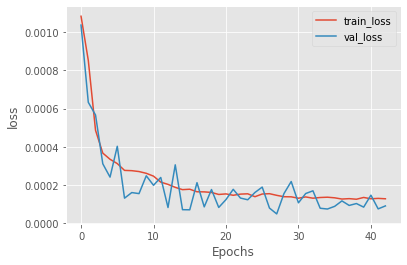

In [46]:
plt.plot(history_Full.history['last_time_step_mse'], label='train_loss')
plt.plot(history_Full.history['val_last_time_step_mse'], label='val_loss')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('loss')

>추가

In [47]:
filename='Wavenet(90_1_1)(plusepochs).h5'
callback_list2 = [tf.keras.callbacks.ModelCheckpoint(filepath='Checkpoint/{}'.format(filename),
                                                    monitor='val_last_time_step_mse',
                                                    verbose=1,
                                                    save_best_only=True,
                                                    mode='min'),
                 tf.keras.callbacks.EarlyStopping(monitor='val_last_time_step_mse',
                                                  patience=15)]

In [48]:
history_Full2= model_Full.fit(X_train_scaled, y_train_scaled, epochs=40,
                    validation_data=(X_valid_scaled,y_valid_scaled),callbacks=callback_list2)

Epoch 1/40
3805/3809 [============================>.] - ETA: 0s - loss: 1.3423e-04 - last_time_step_mse: 1.2937e-04
Epoch 00001: val_last_time_step_mse improved from inf to 0.00006, saving model to Checkpoint/Wavenet(90_1_1)(plusepochs).h5
3809/3809 [==============================] - 79s 21ms/step - loss: 1.3421e-04 - last_time_step_mse: 1.2934e-04 - val_loss: 6.8022e-05 - val_last_time_step_mse: 6.2579e-05
Epoch 2/40
3809/3809 [==============================] - ETA: 0s - loss: 1.3945e-04 - last_time_step_mse: 1.3369e-04
Epoch 00002: val_last_time_step_mse did not improve from 0.00006
3809/3809 [==============================] - 72s 19ms/step - loss: 1.3945e-04 - last_time_step_mse: 1.3369e-04 - val_loss: 1.5220e-04 - val_last_time_step_mse: 1.4752e-04
Epoch 3/40
3806/3809 [============================>.] - ETA: 0s - loss: 1.3261e-04 - last_time_step_mse: 1.2822e-04
Epoch 00003: val_last_time_step_mse did not improve from 0.00006
3809/3809 [==============================] - 73s 19ms/st

Epoch 24/40
3809/3809 [==============================] - ETA: 0s - loss: 1.2252e-04 - last_time_step_mse: 1.1828e-04
Epoch 00024: val_last_time_step_mse did not improve from 0.00005
3809/3809 [==============================] - 69s 18ms/step - loss: 1.2252e-04 - last_time_step_mse: 1.1828e-04 - val_loss: 1.2286e-04 - val_last_time_step_mse: 1.1509e-04
Epoch 25/40
3808/3809 [============================>.] - ETA: 0s - loss: 1.2696e-04 - last_time_step_mse: 1.2272e-04
Epoch 00025: val_last_time_step_mse did not improve from 0.00005
3809/3809 [==============================] - 67s 18ms/step - loss: 1.2697e-04 - last_time_step_mse: 1.2274e-04 - val_loss: 2.1768e-04 - val_last_time_step_mse: 2.2823e-04


Text(0, 0.5, 'loss')

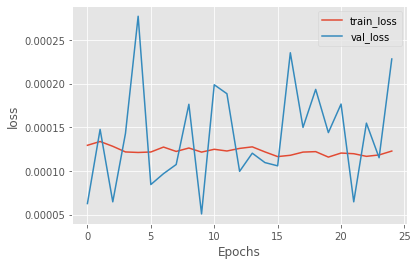

In [50]:
plt.plot(history_Full2.history['last_time_step_mse'], label='train_loss')
plt.plot(history_Full2.history['val_last_time_step_mse'], label='val_loss')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('loss')

>첫번째 모델로 하는게 나음